In [30]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [2]:
# Step 1: Load the point cloud
pcd = o3d.io.read_point_cloud('C:/Users/jessi/OneDrive/Dokument/ProjectCourse/data/2024-09-02_130544_243301-11/raw/tray-b-4-a_L2.pcd')
print(f"Loaded point cloud with {len(pcd.points)} points.")

Loaded point cloud with 32981794 points.


In [3]:
bbox = pcd.get_axis_aligned_bounding_box()
print(f"Bounding box dimensions: {bbox}")

Bounding box dimensions: AxisAlignedBoundingBox: min: (0, -197976, -2067.7), max: (16991.2, -1432, 428.114)


In [4]:
k = 10  # Keep every 5th point
subsampled_pcd = pcd.uniform_down_sample(every_k_points=k)
print(f"Subsampled point cloud to {len(subsampled_pcd.points)} points.")

Subsampled point cloud to 3298180 points.


In [17]:
# Step 3: Apply Statistical Outlier Removal (SOR) to the downsampled point cloud
cl, ind = subsampled_pcd.remove_statistical_outlier(nb_neighbors=300, std_ratio=0.5)

# Step 4: Select inliers (cleaned points) based on SOR result
inlier_cloud = subsampled_pcd.select_by_index(ind)
outlier_cloud = subsampled_pcd.select_by_index(ind, invert=True)

print(f"Number of inliers: {len(inlier_cloud.points)}")
print(f"Number of outliers: {len(outlier_cloud.points)}")
bbox = inlier_cloud.get_axis_aligned_bounding_box()
print(f"Bounding box dimensions: {bbox}")

Number of inliers: 3086512
Number of outliers: 211668


In [53]:
points = np.asarray(inlier_cloud.points)

min_bound = points.min(axis=0)
max_bound = points.max(axis=0)

ranges = max_bound - min_bound
longest_axis_index = np.argmax(ranges)  # Index of the longest axis

# Define midpoints for partitioning along the longest axis
midpoints = np.linspace(min_bound[longest_axis_index], max_bound[longest_axis_index], num=5)

# Define the four parts along the longest axis
if longest_axis_index == 0:  # Longest along x-axis
    parts = [
        points[(points[:, 0] < midpoints[1])],  # Part 1
        points[(points[:, 0] >= midpoints[1]) & (points[:, 0] < midpoints[2])],  # Part 2
        points[(points[:, 0] >= midpoints[2]) & (points[:, 0] < midpoints[3])],  # Part 3
        points[(points[:, 0] >= midpoints[3])],  # Part 4
    ]
elif longest_axis_index == 1:  # Longest along y-axis
    parts = [
        points[(points[:, 1] < midpoints[1])],  # Part 1
        points[(points[:, 1] >= midpoints[1]) & (points[:, 1] < midpoints[2])],  # Part 2
        points[(points[:, 1] >= midpoints[2]) & (points[:, 1] < midpoints[3])],  # Part 3
        points[(points[:, 1] >= midpoints[3])],  # Part 4
    ]
else:  # Longest along z-axis
    parts = [
        points[(points[:, 2] < midpoints[1])],  # Part 1
        points[(points[:, 2] >= midpoints[1]) & (points[:, 2] < midpoints[2])],  # Part 2
        points[(points[:, 2] >= midpoints[2]) & (points[:, 2] < midpoints[3])],  # Part 3
        points[(points[:, 2] >= midpoints[3])],  # Part 4
    ]

# Visualize each part
colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0]]  # Colors for each part: red, green, blue, yellow
part_clouds = []

for i, part in enumerate(parts):
    if part.size > 0:  # Only create a PointCloud if there are points in the part
        part_pcd = o3d.geometry.PointCloud()
        part_pcd.points = o3d.utility.Vector3dVector(part)
        part_pcd.paint_uniform_color(colors[i])  # Set the color for the part
        part_clouds.append(part_pcd)

# Draw the parts
o3d.visualization.draw_geometries(part_clouds, window_name="Partitioned Point Cloud Parts", width=800, height=600)

In [58]:
print(f"Total number of points in point cloud: {len(points)}")
print(f"Bounding box min: {min_bound}, max: {max_bound}")

# Check the sizes of each part after segmentation
for i, part in enumerate(parts):
    print(f"Part {i + 1} size: {part.shape[0]} points")


Total number of points in point cloud: 3086512
Bounding box min: [ 6.64690781e+01 -1.97056000e+05 -1.75918481e+03], max: [16924.68945312 -1536.           -25.90167236]
Part 1 size: 771835 points
Part 2 size: 771450 points
Part 3 size: 773741 points
Part 4 size: 769486 points


In [75]:
# Step 2: Apply DBSCAN to each part and visualize the clusters
eps = 350.0  # Adjust based on your analysis
min_samples = 100  # Set this value based on the density of the data

# List to hold clusters from each part
clustered_parts = []

for i, part in enumerate(parts):
    if part.size > 0:  # Only process non-empty parts
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(part)

        # Store the clustered points
        clustered_parts.append((i, part, labels))  # Store the part index, points, and labels

        # Print the number of unique clusters found
        unique_labels = set(labels)
        print(f"Part {i + 1}: Unique clusters found: {len(unique_labels) - (1 if -1 in unique_labels else 0)}")

# Step 3: Further divide each part into 2 clusters
for part_index, part, labels in clustered_parts:
    unique_labels = set(labels)
    
    # Filter out noise
    non_noise_labels = [label for label in unique_labels if label != -1]
    
    for cluster_label in non_noise_labels:
        # Get points belonging to this cluster
        cluster_points = part[labels == cluster_label]
        
        # Check if the cluster has enough points to apply DBSCAN
        if len(cluster_points) > 10:  # Adjust this threshold as necessary
            # Apply DBSCAN to further cluster this part into 2 clusters
            sub_dbscan = DBSCAN(eps=0.2, min_samples=3)  # Adjust eps and min_samples for finer clustering
            sub_labels = sub_dbscan.fit_predict(cluster_points)

            # Visualize the results of the new clustering
            plt.figure(figsize=(8, 6))
            unique_sub_labels = set(sub_labels)
            for sub_label in unique_sub_labels:
                color = [0.5, 0.5, 0.5] if sub_label == -1 else plt.cm.viridis(sub_label / len(unique_sub_labels))
                sub_class_member_mask = (sub_labels == sub_label)
                xyz = cluster_points[sub_class_member_mask]

                plt.scatter(xyz[:, 0], xyz[:, 1], color=color, s=5)  # s is the marker size
            
            plt.title(f"DBSCAN Results for Part {part_index + 1} Cluster {cluster_label}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.axis('equal')
            plt.show()
        else:
            print(f"Cluster {cluster_label} in Part {part_index + 1} is too small for further clustering.")

Part 1: Unique clusters found: 9


KeyboardInterrupt: 

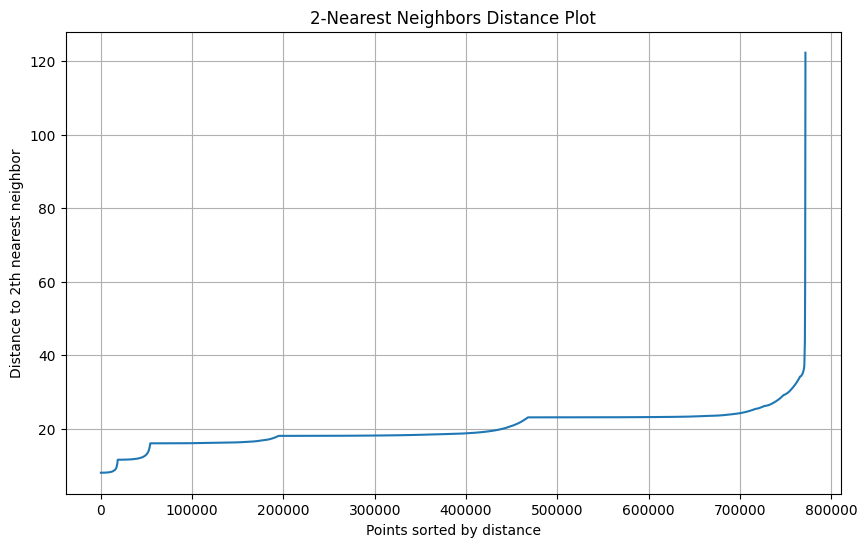

In [52]:
# Compute k-nearest neighbors
points = np.asarray(inlier_cloud.points)
k = 4  # You can adjust this value
nbrs = NearestNeighbors(n_neighbors=k).fit(points)
distances, indices = nbrs.kneighbors(points)

# Sort the distances
distances = np.sort(distances[:, k-1], axis=0)

# Plotting the distance
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f"{k}-Nearest Neighbors Distance Plot")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to {}th nearest neighbor".format(k))
plt.grid()
plt.show()

In [19]:
outlier_cloud.paint_uniform_color([1, 0, 0])  # Red for outlier
inlier_cloud.paint_uniform_color([0, 1, 0])   # Green for inliers

combined_pcd = outlier_cloud + inlier_cloud

o3d.visualization.draw_geometries([combined_pcd], window_name="Anomaly Detection Results", width=800, height=600)
#o3d.io.write_point_cloud("combined_point_cloud.ply", combined_pcd)

Labels: [-1 -1 -1 ... -1 -1 -1]
Unique Labels: {-1}


C:\Users\jessi\AppData\Local\Temp\ipykernel_6416\1132188205.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


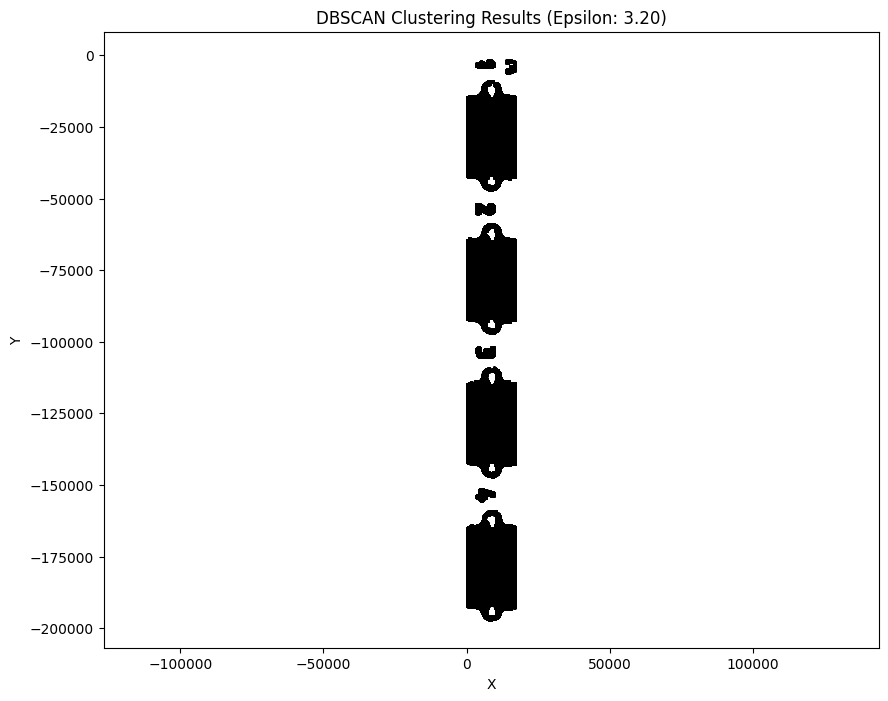

In [38]:
points = np.asarray(inlier_cloud.points)
eps = 3.2  # Initial epsilon value, adjust this as needed
min_samples = 10000  # Minimum number of points to form a cluster

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(points)

unique_labels = set(labels)
    
print(f"Labels: {labels}")
print(f"Unique Labels: {unique_labels}")

# Visualize the results
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('viridis', len(unique_labels))

for k in unique_labels:
    if k == -1:
        color = [0, 0, 0]  # Black for noise
    else:
        color = colors(k)
    
    class_member_mask = (labels == k)
    xyz = points[class_member_mask]
    
    # Plot the points
    plt.scatter(xyz[:, 0], xyz[:, 1], color=color, s=1)  # s is the marker size

plt.title(f"DBSCAN Clustering Results (Epsilon: {eps:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')  # Keep aspect ratio
plt.show()